In [1]:
import pandas as pd
import sklearn
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, roc_auc_score

## First look

In [2]:
main_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
PassengerID = test_df['PassengerId']

In [3]:
main_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## Dealing with NaNs

In [5]:
main_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
def get_rid_of_nans(df):
    df['Age'].fillna(value = df['Age'].mean(), inplace = True)
    df['Fare'].fillna(value = df['Fare'].mean(), inplace = True)
    df['Embarked'].fillna(value = df['Embarked'].mode()[0], inplace = True)
    df['Cabin'].fillna(value = 'NoCabin', inplace = True)
    re_cabin_template = "[A-Za-z]+"
    df['Cabin'] = df['Cabin'].apply(lambda x: re.search(re_cabin_template, x).group(0))

In [8]:
get_rid_of_nans(main_df)
get_rid_of_nans(test_df)

In [9]:
main_df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## Feature engineering

In [10]:
def make_title(df):
    re_title_template = '([A-Za-z]+)\.'
    df['Title'] = df.Name.apply(lambda x: re.search(re_title_template, x).group(1))

In [11]:
make_title(main_df)
make_title(test_df)

In [12]:
main_df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Lady          1
Capt          1
Ms            1
Don           1
Mme           1
Sir           1
Countess      1
Jonkheer      1
Name: Title, dtype: int64

In [13]:
def replace_title_name(x):
    title = x['Title']
    man_mr_titles = ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']
    woman_mrs_titles = ['Countess', 'Mme','Dona']
    woman_miss_titles = ['Mlle', 'Ms','Lady']
    if title in man_mr_titles:
        return 'Mr'
    elif title in woman_mrs_titles:
        return 'Mrs'
    elif title in woman_miss_titles:
        return 'Miss'
    elif title =='Dr':
        if x['Sex'] == 'Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [14]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,NoCabin,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,NoCabin,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,NoCabin,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,NoCabin,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,NoCabin,S,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,NoCabin,S,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C,C,Dona
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,NoCabin,S,Mr
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,NoCabin,S,Mr


In [15]:
main_df['Title'] = main_df.apply(replace_title_name, axis = 1)
test_df['Title'] = test_df.apply(replace_title_name, axis = 1)

In [16]:
main_df.Title.value_counts()

Mr        531
Miss      186
Mrs       134
Master     40
Name: Title, dtype: int64

In [17]:
test_df.Title.value_counts()

Mr        244
Miss       79
Mrs        74
Master     21
Name: Title, dtype: int64

In [18]:
def make_features(df):
    children_with_nanny = (df['Age']<18) & (df['Parch']==0)
    df['Family_Size'] = df['SibSp'] + df['Parch']
    # children without parents travell with nanny
    df.Family_Size[children_with_nanny] = df.apply(lambda x: x['SibSp'] + 1, axis = 1)
    # family size and the person himself
    df['Fare_Per_Person'] = df['Fare'] / (df['Family_Size'] + 1)
    df['Age*Class'] = df['Age'] * df['Pclass']

In [19]:
make_features(main_df)
make_features(test_df)

<ipython-input-18-e57317e3a635>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Family_Size[children_with_nanny] = df.apply(lambda x: x['SibSp'] + 1, axis = 1)
<ipython-input-18-e57317e3a635>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Family_Size[children_with_nanny] = df.apply(lambda x: x['SibSp'] + 1, axis = 1)


In [20]:
def drop_columns(df):
    columns_to_drop = ['PassengerId', 'Ticket', 'Embarked','Name']
    df.drop(columns = columns_to_drop, inplace = True)
#     columns_to_drop = ['SibSp', 'Parch', 'Fare']
#     df.drop(columns = columns_to_drop, inplace = True)

In [21]:
drop_columns(main_df)
drop_columns(test_df)

## Data preprocessing

In [22]:
rand_state = 200

In [23]:
main_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Title,Family_Size,Fare_Per_Person,Age*Class
0,0,3,male,22.000000,1,0,7.2500,NoCabin,Mr,1,3.62500,66.000000
1,1,1,female,38.000000,1,0,71.2833,C,Mrs,1,35.64165,38.000000
2,1,3,female,26.000000,0,0,7.9250,NoCabin,Miss,0,7.92500,78.000000
3,1,1,female,35.000000,1,0,53.1000,C,Mrs,1,26.55000,35.000000
4,0,3,male,35.000000,0,0,8.0500,NoCabin,Mr,0,8.05000,105.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,NoCabin,Mr,0,13.00000,54.000000
887,1,1,female,19.000000,0,0,30.0000,B,Miss,0,30.00000,19.000000
888,0,3,female,29.699118,1,2,23.4500,NoCabin,Miss,3,5.86250,89.097353
889,1,1,male,26.000000,0,0,30.0000,C,Mr,0,30.00000,26.000000


In [24]:
main_df.dtypes

Survived             int64
Pclass               int64
Sex                 object
Age                float64
SibSp                int64
Parch                int64
Fare               float64
Cabin               object
Title               object
Family_Size          int64
Fare_Per_Person    float64
Age*Class          float64
dtype: object

In [25]:
def encoding_columns(df):
    LE = LabelEncoder()
    for feature in df.select_dtypes(include = ['object']):
        df[feature] = LE.fit_transform(df[feature])
    return 

In [26]:
encoding_columns(main_df)
encoding_columns(test_df)

In [27]:
train_data, valid_data, train_value, valid_value  = train_test_split(main_df.drop(columns = ['Survived']), main_df['Survived'], test_size = 0.2, random_state = rand_state, shuffle = True)

## Building and train ML Model

In [28]:
def get_ml_model():
    tuned_parameters = [{'n_estimators': [100, 200, 300, 500],
                     'max_depth': [5,7,9,12,15,18], 'max_samples': [100, 150, 200]}]
    # RFC = RandomForestClassifier(n_estimators = 100, max_depth = 3, min_samples_split = 10, min_samples_leaf = 5, random_state = rand_state, max_samples = 200)
    Random_Forest = RandomForestClassifier(random_state = rand_state, min_samples_split = 10, min_samples_leaf = 5, criterion = 'entropy')
    RFC = GridSearchCV(Random_Forest, tuned_parameters)
    return RFC

In [29]:
RFC = get_ml_model()

In [30]:
RFC.fit(train_data, train_value)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                              min_samples_leaf=5,
                                              min_samples_split=10,
                                              random_state=200),
             param_grid=[{'max_depth': [5, 7, 9, 12, 15, 18],
                          'max_samples': [100, 150, 200],
                          'n_estimators': [100, 200, 300, 500]}])

In [31]:
value_predicted = RFC.predict(valid_data)

## Wriring results to CSV file submission

In [32]:
test_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Title,Family_Size,Fare_Per_Person,Age*Class
0,3,1,34.50000,0,0,7.8292,7,2,0,7.829200,103.500000
1,3,0,47.00000,1,0,7.0000,7,3,1,3.500000,141.000000
2,2,1,62.00000,0,0,9.6875,7,2,0,9.687500,124.000000
3,3,1,27.00000,0,0,8.6625,7,2,0,8.662500,81.000000
4,3,0,22.00000,1,1,12.2875,7,3,2,4.095833,66.000000
...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,30.27259,0,0,8.0500,7,2,0,8.050000,90.817771
414,1,0,39.00000,0,0,108.9000,2,3,0,108.900000,39.000000
415,3,1,38.50000,0,0,7.2500,7,2,0,7.250000,115.500000
416,3,1,30.27259,0,0,8.0500,7,2,0,8.050000,90.817771


In [33]:
def make_csv_sub(df, PassengerID, rfc_classifier):
    test_predictions = RFC.predict(df)
    submit_df = pd.DataFrame({"PassengerID": PassengerID, "Survived": test_predictions})
    submit_df.to_csv("gender_submission.csv", index = False)

In [34]:
make_csv_sub(test_df, PassengerID, RFC)

## PostHoc Analysis

In [35]:
RFC.best_estimator_.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(criterion='entropy', max_depth=15, max_samples=200,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=300, random_state=200)>

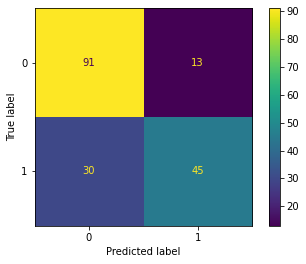

In [36]:
plot_confusion_matrix(RFC, valid_data, valid_value)

In [37]:
def make_report(y_test, y_pred):
    print(classification_report(y_test,y_pred))
    print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
    print("ROC-AUC score: {}".format(roc_auc_score(valid_value, value_predicted)))

In [38]:
make_report(valid_value, value_predicted)

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       104
           1       0.78      0.60      0.68        75

    accuracy                           0.76       179
   macro avg       0.76      0.74      0.74       179
weighted avg       0.76      0.76      0.75       179

Accuracy score: 0.7597765363128491
ROC-AUC score: 0.7375


In [39]:
feature_imp_df = pd.DataFrame({'Feature': train_data.columns , 'Importance':RFC.best_estimator_.feature_importances_ })
feature_imp_df = feature_imp_df.sort_values('Importance', ascending = False)
feature_imp_df

,Feature,Importance
1,Sex,0.255173
7,Title,0.132710
10,Age*Class,0.124429
9,Fare_Per_Person,0.123239
5,Fare,0.104385
2,Age,0.073052
0,Pclass,0.065294
8,Family_Size,0.043563
6,Cabin,0.040925
3,SibSp,0.025889


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

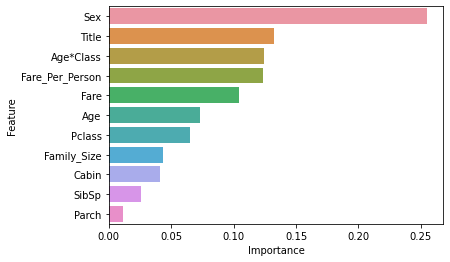

In [40]:
sns.barplot(x = feature_imp_df['Importance'], y = feature_imp_df['Feature'] )

## Make new model based on knowledge of feature importance

In [41]:
print("Number of all features: {}".format(len(train_data.columns)))

Number of all features: 11


In [42]:
N_features = 9
selected_imp_features = feature_imp_df['Feature'][:N_features].to_list()

In [43]:
selected_imp_features

['Sex',
 'Title',
 'Age*Class',
 'Fare_Per_Person',
 'Fare',
 'Age',
 'Pclass',
 'Family_Size',
 'Cabin']

In [44]:
test_df_most_imp = test_df[selected_imp_features]

In [45]:
selected_imp_features.append("Survived")
main_df_most_imp = main_df[selected_imp_features]

In [46]:
train_data, valid_data, train_value, valid_value  = train_test_split(main_df_most_imp.drop(columns = ['Survived']), main_df_most_imp['Survived'], test_size = 0.2, random_state = rand_state, shuffle = True)

In [47]:
RFC.fit(train_data, train_value)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                              min_samples_leaf=5,
                                              min_samples_split=10,
                                              random_state=200),
             param_grid=[{'max_depth': [5, 7, 9, 12, 15, 18],
                          'max_samples': [100, 150, 200],
                          'n_estimators': [100, 200, 300, 500]}])

In [48]:
value_predicted = RFC.predict(valid_data)

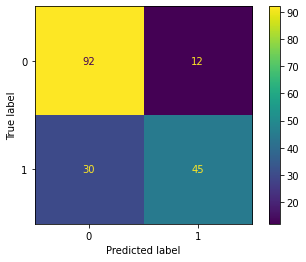

In [49]:
plot_confusion_matrix(RFC, valid_data, valid_value)

In [50]:
make_report(valid_value, value_predicted)

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       104
           1       0.79      0.60      0.68        75

    accuracy                           0.77       179
   macro avg       0.77      0.74      0.75       179
weighted avg       0.77      0.77      0.76       179

Accuracy score: 0.7653631284916201
ROC-AUC score: 0.7423076923076923


In [51]:
make_csv_sub(test_df_most_imp, PassengerID, RFC)